In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
from apra_pop_models.math_module import xp, _scipy, ensure_np_array
import apra_pop_models.fresnel_2dm_34 as fresnel
import apra_pop_models.fraunhofer_2dm_34 as fraunhofer
import apra_pop_models.utils as utils
import apra_pop_models.props as props
from apra_pop_models.imshows import imshow1, imshow2, imshow3
import apra_pop_models.adefc_2dm as adefc
import apra_pop_models.efc_utils as efc_utils

from scipy.optimize import minimize



/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


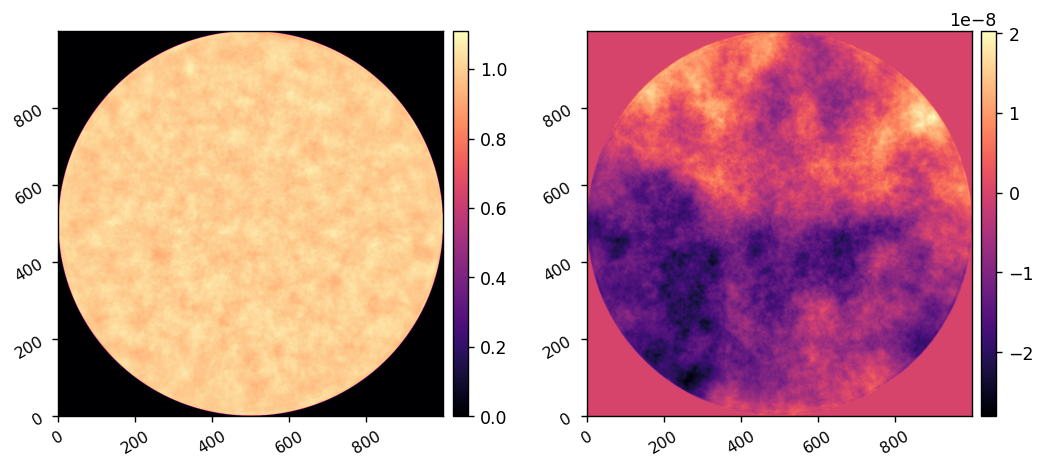

In [2]:
reload(fresnel)
I = fresnel.CORO()
I.use_opds = True

AMP, OPD = I.calc_pupil()
imshow2(AMP, OPD)

/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


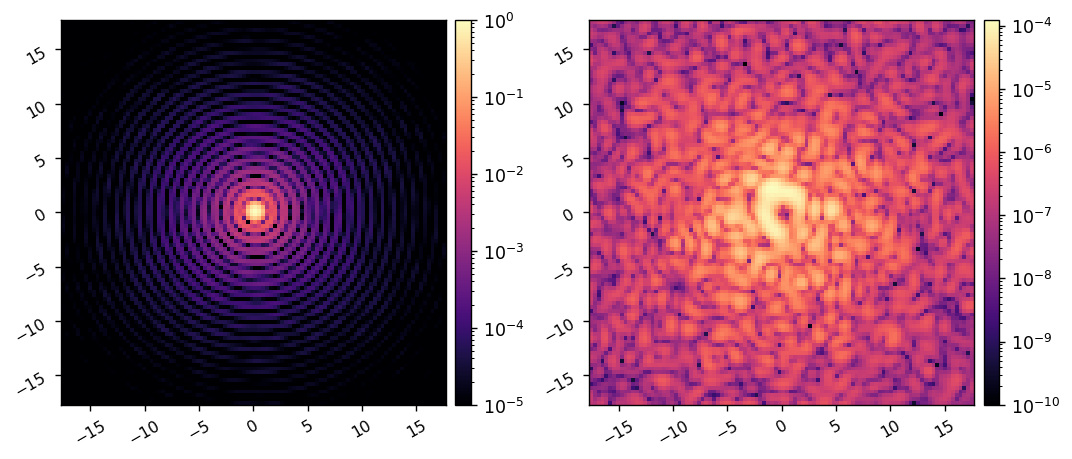

In [3]:
reload(fresnel)
I = fresnel.CORO()
I.use_opds = True

I.use_vortex = False
ref_psf = I.snap()
I.Imax_ref = xp.max(ref_psf)
ref_psf /= I.Imax_ref
I.use_vortex = True
ref_coro_im = I.snap()

imshow2(ref_psf, ref_coro_im,
        pxscl=I.psf_pixelscale_lamDc, lognorm=True, vmin1=1e-5, vmin2=1e-10)


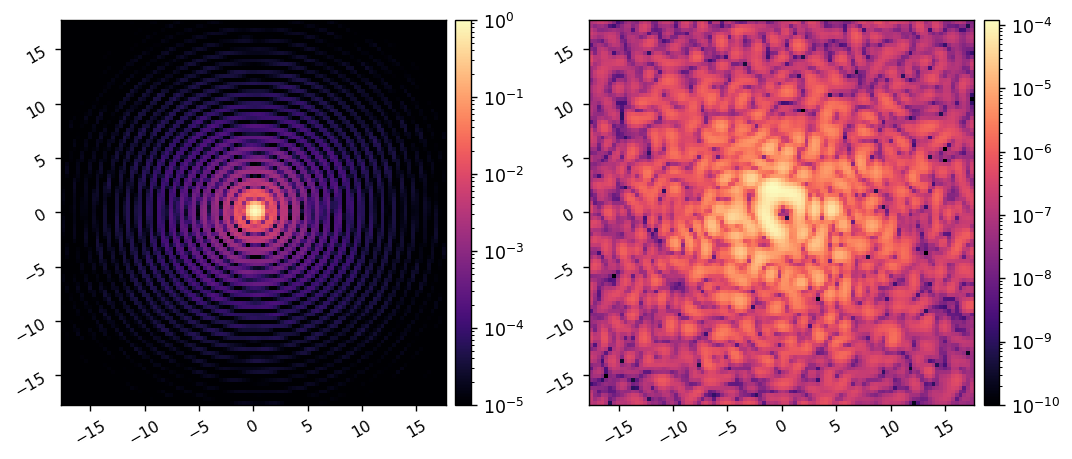

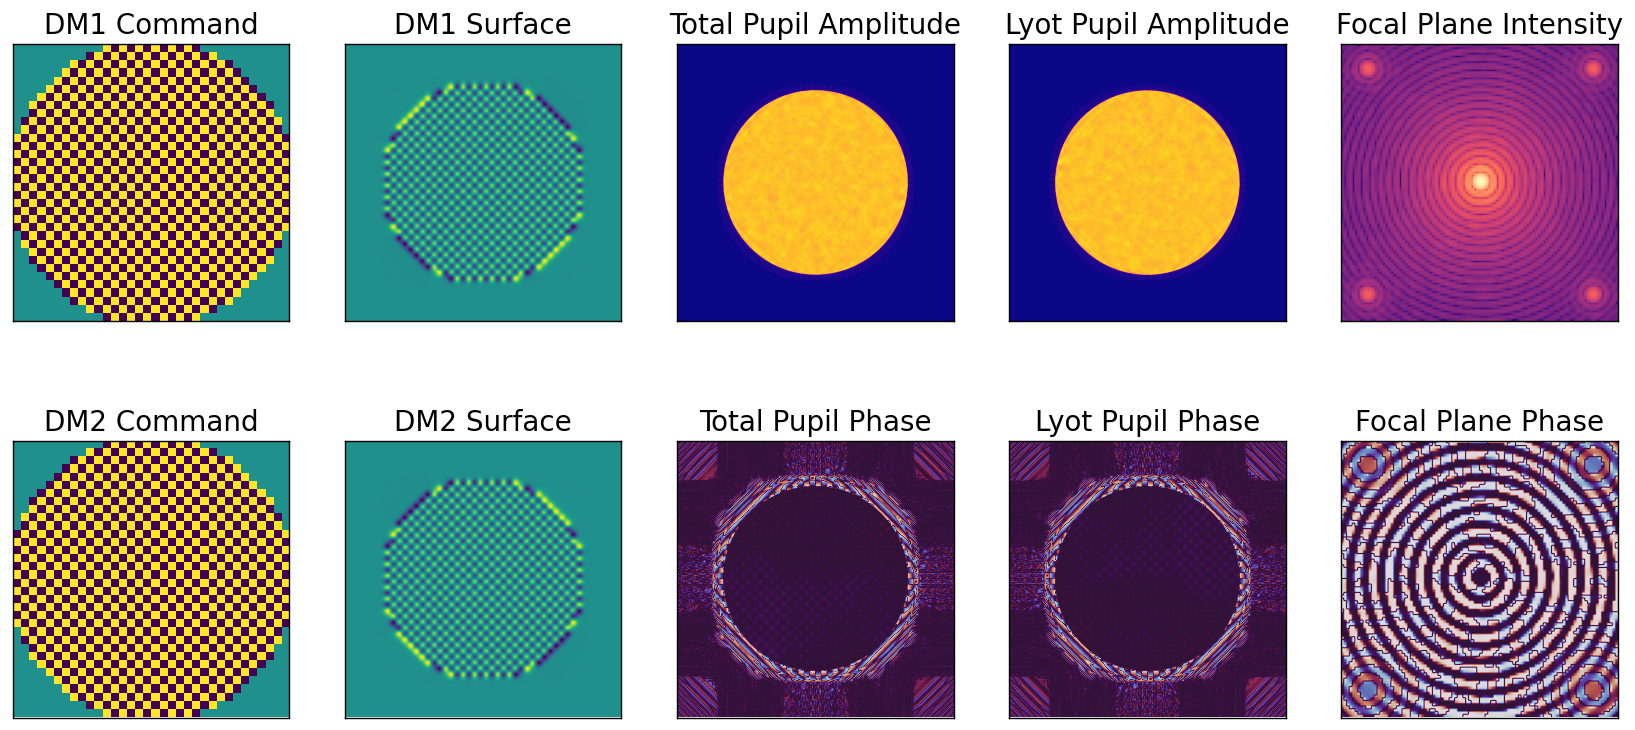

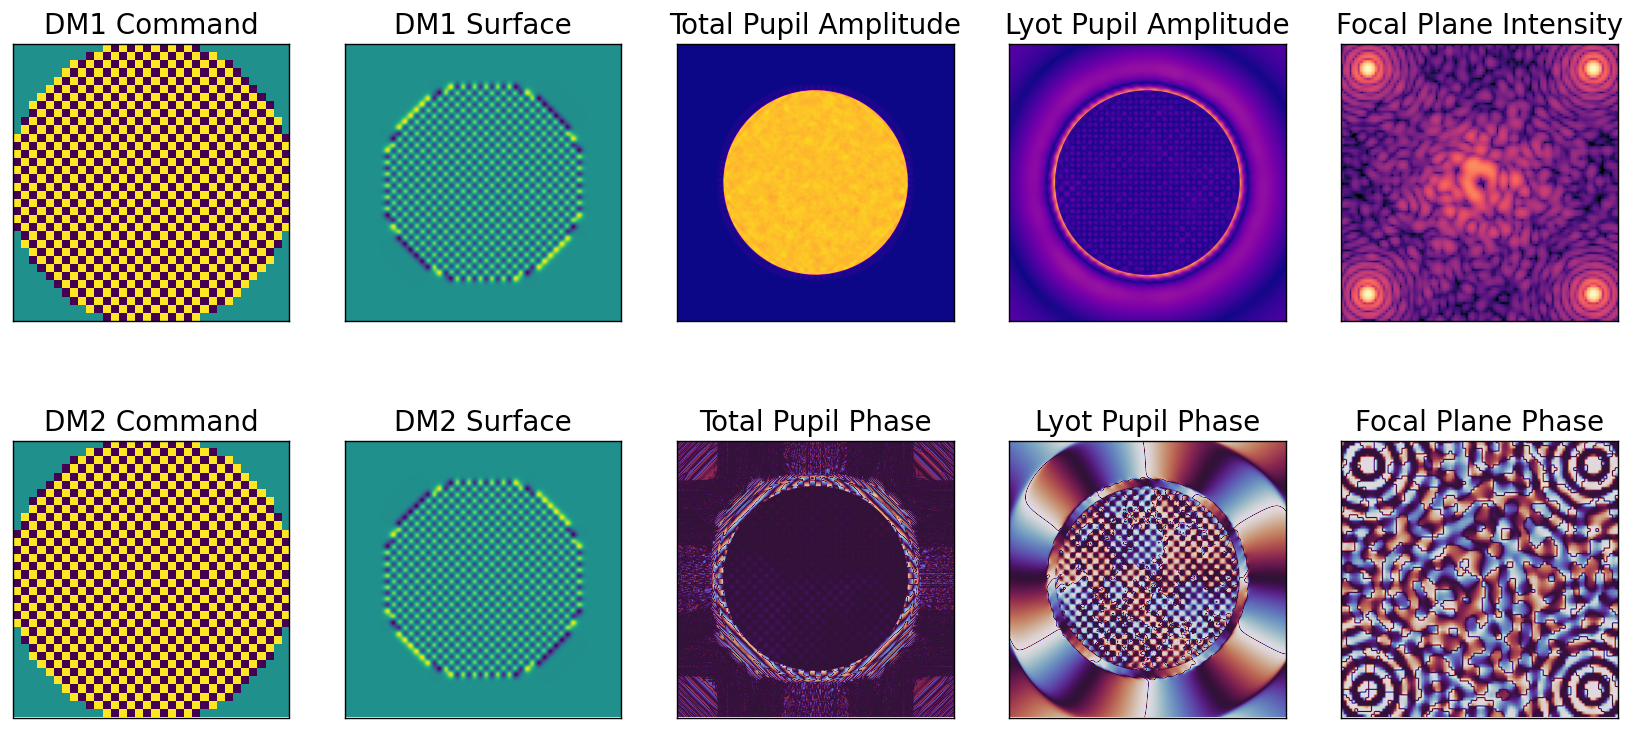

In [4]:
reload(fraunhofer)
M = fraunhofer.MODEL()
M.AMP = AMP
M.OPD = OPD

M.flip_dm = True
M.flip_lyot = True

M.setattr('use_vortex', False)
model_psf = xp.abs(M.calc_wf())**2
M.setattr('Imax_ref', xp.max(model_psf))
model_psf /= M.Imax_ref

M.setattr('use_vortex', True)
model_coro_im = xp.abs(M.calc_wf())**2

imshow2(model_psf, model_coro_im,
        pxscl=M.psf_pixelscale_lamDc, lognorm=True, vmin1=1e-5, vmin2=1e-10)

dm1_command, dm2_command = ( xp.zeros((M.Nact, M.Nact)), xp.zeros((M.Nact, M.Nact)) )
# command = 50e-9*utils.make_f(h=10, w=6, shift=(0,0))
dm1_command = 10e-9*utils.make_fourier_command(x_cpa=17, y_cpa=17)
dm2_command = -10e-9*utils.make_fourier_command(x_cpa=17, y_cpa=17)

acts = xp.concatenate([dm1_command[M.dm_mask], dm2_command[M.dm_mask]])
fpwf = M.forward(acts, M.wavelength_c, use_vortex=0, fancy_plot=1)
fpwf = M.forward(acts, M.wavelength_c, use_vortex=1, fancy_plot=1)

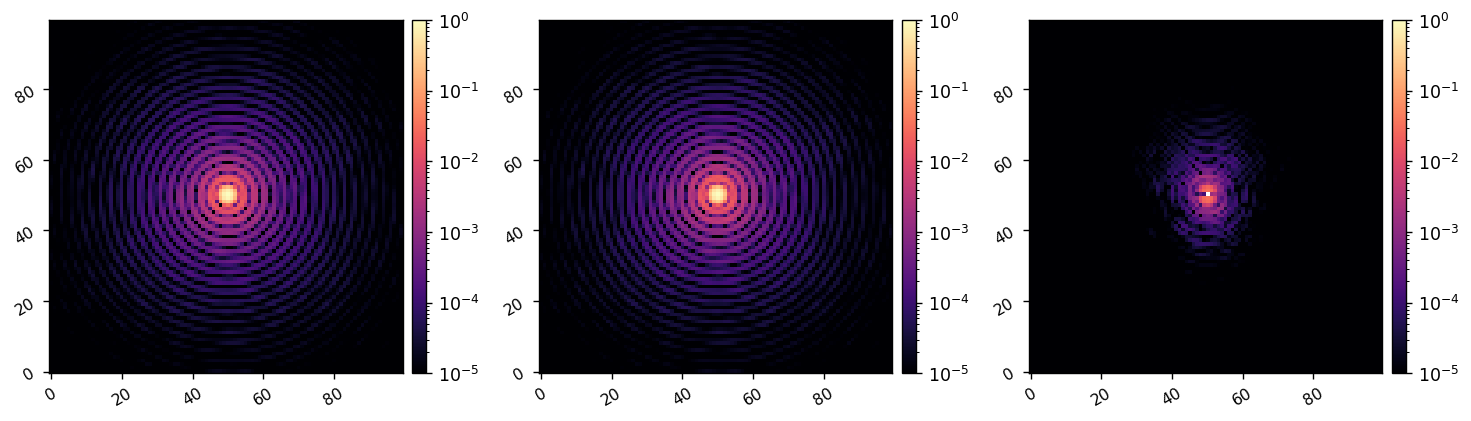

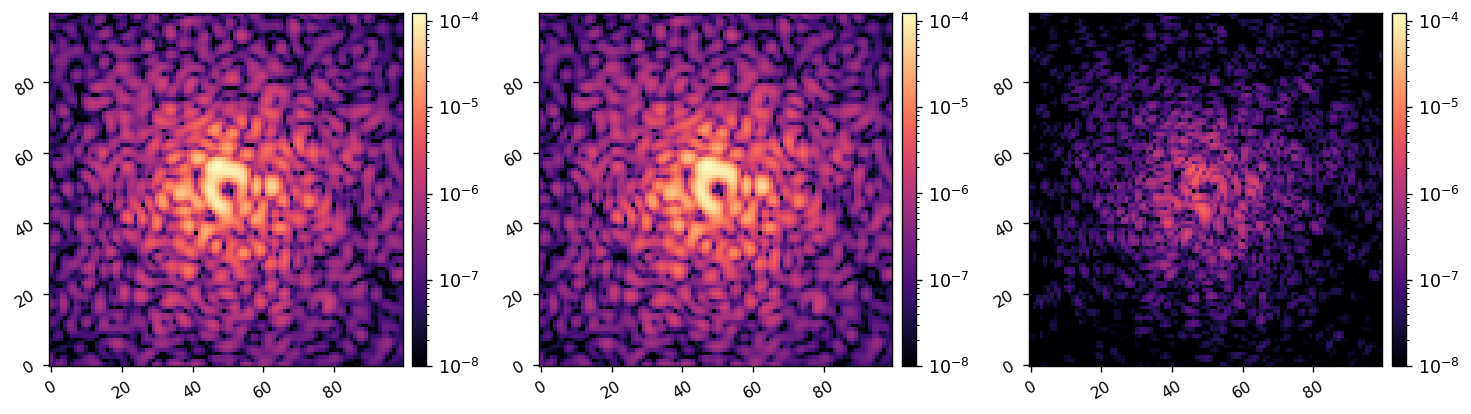

In [5]:
imshow3(ref_psf, model_psf, xp.abs(ref_psf - model_psf), 
        lognorm1=True, lognorm2=True, lognorm3=True, vmax3=1, 
        vmin1=1e-5, vmin2=1e-5, vmin3=1e-5)

imshow3(ref_coro_im, model_coro_im, xp.abs(ref_coro_im - model_coro_im), 
        lognorm1=True, lognorm2=True, lognorm3=True, vmax3=xp.max(ref_coro_im), 
        vmin1=1e-8, vmin2=1e-8, vmin3=1e-8)

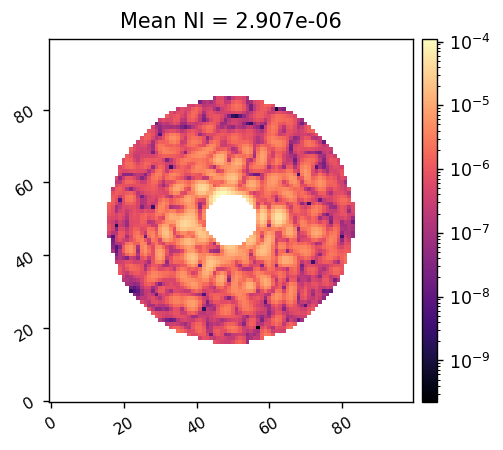

In [6]:
reload(efc_utils)
I.zero_dms()
iwa = 2.5
owa = 12
rot = 0
control_mask = efc_utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, irad=iwa, orad=owa, edge=None, rotation=rot)
mean_ni = xp.mean(ref_coro_im[control_mask])

imshow1(ref_coro_im*control_mask, f'Mean NI = {mean_ni:.3e}', lognorm=True)


	Cost-function J_delE: 0.010
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.010
	Total cost-function value: 1.000



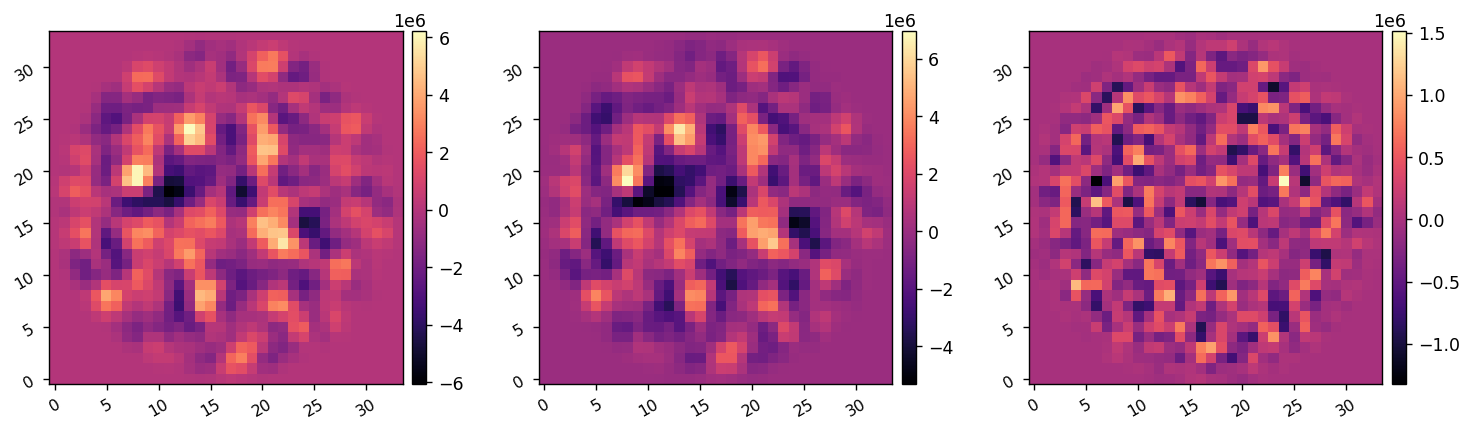

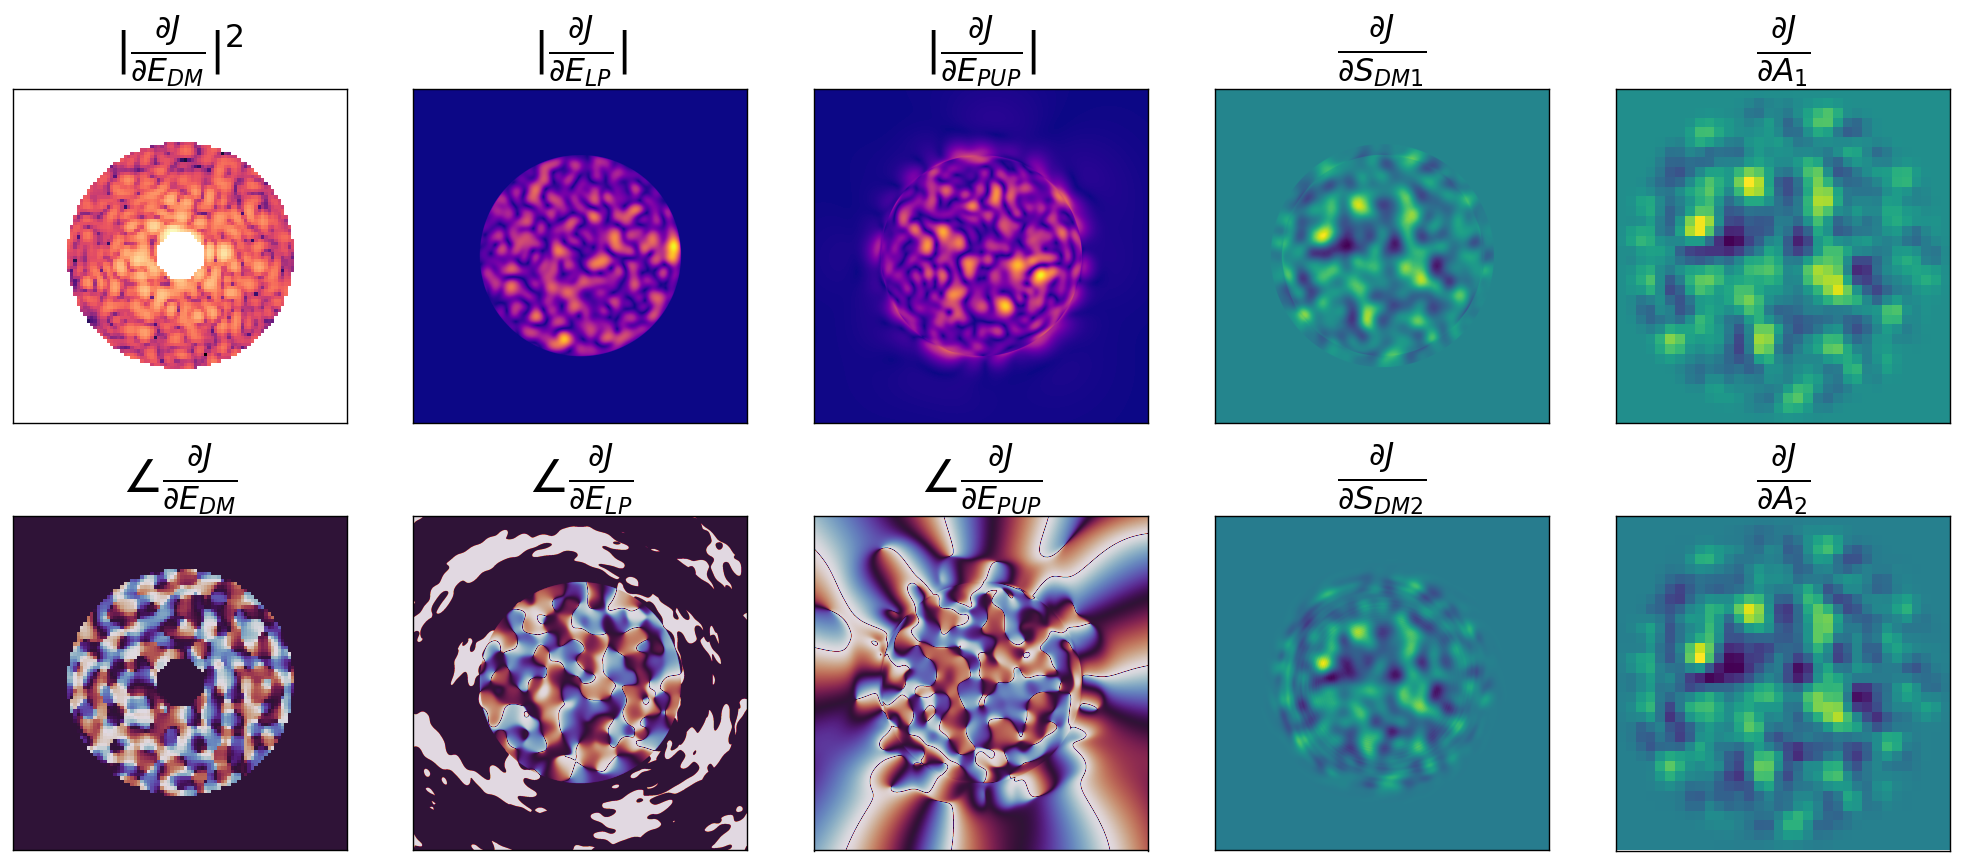

In [10]:
reload(fraunhofer)
from apra_pop_models import imshows
reload(imshows)
current_acts = xp.zeros(M.Nacts)
# current_acts = fits.getdata('example-data/ad_test_acts.fits')

I.set_dm1(fraunhofer.acts_to_command(current_acts[:M.Nacts//2], M.dm_mask))
I.set_dm2(fraunhofer.acts_to_command(current_acts[M.Nacts//2:], M.dm_mask))
E_ab = I.calc_wf() * control_mask
r_cond = 1e-3

E_FP_nom, E_EP, E_DM2P, DM1_PHASOR, DM2_PHASOR = M.forward(current_acts, I.wavelength, use_vortex=True, return_ints=True,)
rmad_vars ={
    'E_FP_nom':E_FP_nom,
    'E_EP':E_EP,
    'E_DM2P':E_DM2P,
    'DM1_PHASOR':DM1_PHASOR,
    'DM2_PHASOR':DM2_PHASOR,
}

del_acts = np.zeros(M.Nacts)
J, dJ_dA = fraunhofer.val_and_grad(del_acts, M, current_acts, E_ab, control_mask, M.wavelength_c, r_cond, rmad_vars,
                                    verbose=True, 
                                    # plot=True, 
                                    fancy_plot=True)

dm1_grad = fraunhofer.acts_to_command(dJ_dA[:M.Nacts//2], M.dm_mask)
dm2_grad = fraunhofer.acts_to_command(dJ_dA[M.Nacts//2:], M.dm_mask)
imshow3(dm1_grad, dm2_grad, dm2_grad-dm1_grad)

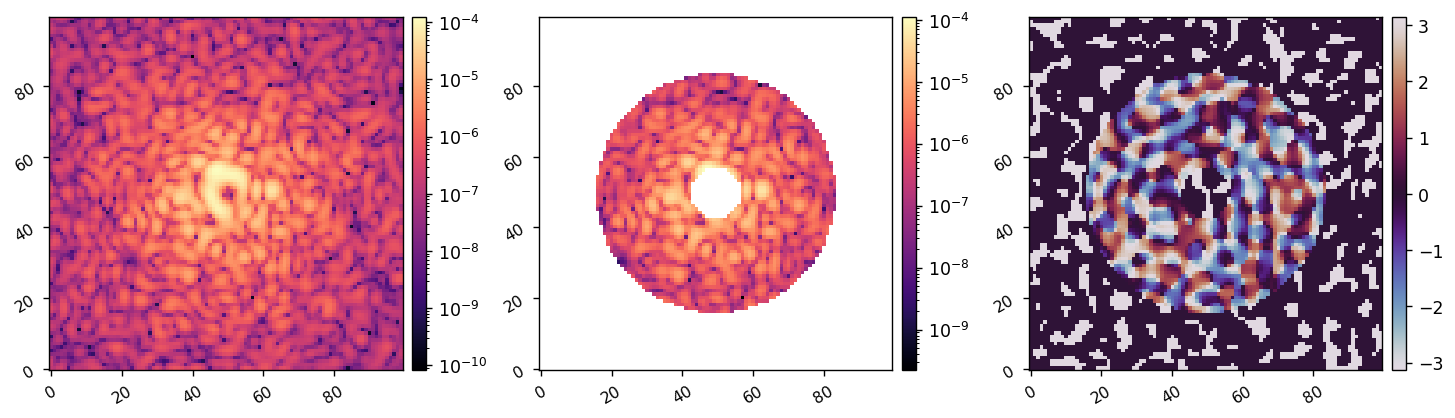

	Cost-function J_delE: 0.010
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.010
	Total cost-function value: 1.000

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1904     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  6.96691D+06
	Cost-function J_delE: 0.001
	Cost-function J_c: 2366863905.325
	Cost-function normalization factor: 0.010
	Total cost-function value: 236411157562.321



 This problem is unconstrained.


	Cost-function J_delE: 0.030
	Cost-function J_c: 5.828
	Cost-function normalization factor: 0.010
	Total cost-function value: 585.038

	Cost-function J_delE: 0.738
	Cost-function J_c: 0.369
	Cost-function normalization factor: 0.010
	Total cost-function value: 110.530

	Cost-function J_delE: 4.448
	Cost-function J_c: 0.017
	Cost-function normalization factor: 0.010
	Total cost-function value: 446.005

	Cost-function J_delE: 0.313
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.010
	Total cost-function value: 31.269

	Cost-function J_delE: 0.003
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.010
	Total cost-function value: 0.286


At iterate    1    f=  2.86444D-01    |proj g|=  2.07969D+06
	Cost-function J_delE: 0.002
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.010
	Total cost-function value: 0.172


At iterate    2    f=  1.72124D-01    |proj g|=  1.05709D+06
	Cost-function J_delE: 0.001
	Cost-function J_c: 0.000
	Cost-function n

In [ ]:
reload(fraunhofer)

current_acts = xp.zeros(M.Nacts)
# current_acts = fits.getdata('example-data/ad_test_acts.fits')

I.set_dm1(fraunhofer.acts_to_command(current_acts[:M.Nacts//2], M.dm_mask))
I.set_dm2(fraunhofer.acts_to_command(current_acts[M.Nacts//2:], M.dm_mask))
E_ab = I.calc_wf() * control_mask
coro_im = I.snap()
imshow3(coro_im, xp.abs(E_ab)**2, xp.angle(E_ab), lognorm1=True, lognorm2=True, cmap3='twilight')

E_FP_nom, E_EP, E_DM2P, DM1_PHASOR, DM2_PHASOR = M.forward(current_acts, I.wavelength, use_vortex=True, return_ints=True,)

rmad_vars = { 
    'current_acts':current_acts,
    'E_ab':E_ab, 
    'E_FP_nom':E_FP_nom,
    'E_EP':E_EP,
    'E_DM2P':E_DM2P,
    'DM1_PHASOR':DM1_PHASOR,
    'DM2_PHASOR':DM2_PHASOR,
    'control_mask':control_mask,
    'wavelength':I.wavelength,
    'r_cond':1e-3,
}

bfgs_tol = 1e-3
bfgs_opts = {
    'disp':True,
    # 'maxls':50,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

del_acts0 = np.zeros(M.Nacts)
res = minimize(fraunhofer.val_and_grad, 
                jac=True, 
                x0=del_acts0,
                args=(M, rmad_vars, True, False), 
                method='L-BFGS-B',
                tol=bfgs_tol,
                options=bfgs_opts,
                )


2.906980874319683e-06 3.483969558809897e-08


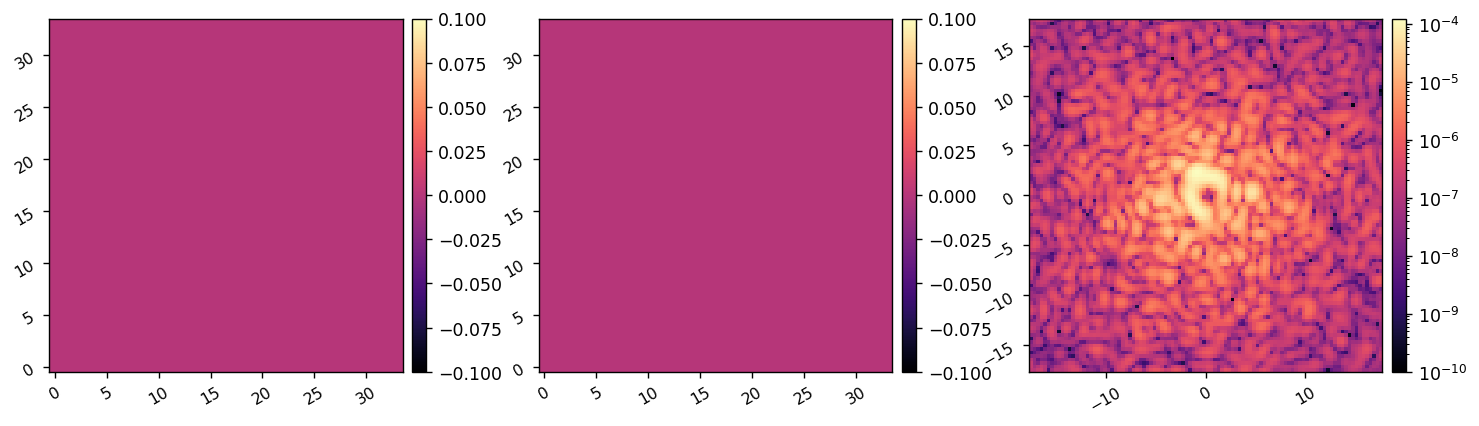

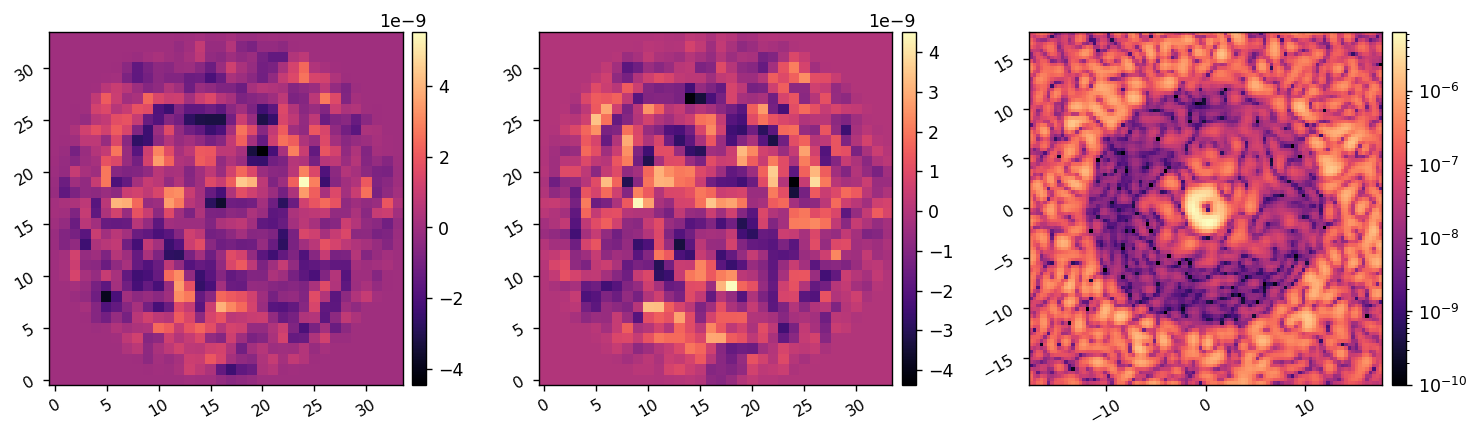

In [19]:
old_dm1 = fraunhofer.acts_to_command(acts[:M.Nacts//2], I.dm_mask)
old_dm2 = fraunhofer.acts_to_command(acts[M.Nacts//2:], I.dm_mask)
del_dm1 = fraunhofer.acts_to_command(res.x[:M.Nacts//2], I.dm_mask)
del_dm2 = fraunhofer.acts_to_command(res.x[M.Nacts//2:], I.dm_mask)

I.set_dm1(old_dm1 + del_dm1)
I.set_dm2(old_dm2 + del_dm2)
new_im = I.snap()

print(xp.mean(coro_im[control_mask]), xp.mean(new_im[control_mask]))
imshow3(old_dm1, old_dm2, coro_im, lognorm3=True, pxscl3=I.psf_pixelscale_lamDc, vmin3=1e-10,)
imshow3(del_dm1, del_dm2, new_im, lognorm3=True, pxscl3=I.psf_pixelscale_lamDc, vmin3=1e-10,)

In [18]:
utils.save_fits('ad_test_acts.fits', res.x)

Saved data to:  ad_test_acts.fits


In [20]:
I.zero_dms()
data = {
    # 'ref_im':ref_coro_im, 
    'images':[ref_coro_im],
    'efields':[],
    'dm1_commands':[],
    'del_dm1_commands':[],
    'dm2_commands':[],
    'del_dm2_commands':[],
    'reg_conds':[],
    'bfgs_tols':[],
    'pixelscale':I.psf_pixelscale_lamDc,
    'control_mask':control_mask, 
}

Running estimation algorithm ...
Computing EFC command with L-BFGS
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1904     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  1.21528D+08


 This problem is unconstrained.



At iterate    1    f=  9.56872D-01    |proj g|=  8.88292D+07

At iterate    2    f=  9.32633D-01    |proj g|=  5.92459D+07

At iterate    3    f=  8.84353D-01    |proj g|=  4.77552D+07

At iterate    4    f=  8.67392D-01    |proj g|=  9.96766D+07

At iterate    5    f=  8.46696D-01    |proj g|=  4.93674D+07

At iterate    6    f=  8.18865D-01    |proj g|=  3.63172D+07

At iterate    7    f=  8.02552D-01    |proj g|=  4.12065D+07

At iterate    8    f=  7.87058D-01    |proj g|=  1.10204D+08

At iterate    9    f=  7.59743D-01    |proj g|=  2.95786D+07

At iterate   10    f=  7.51031D-01    |proj g|=  2.36066D+07

At iterate   11    f=  7.30720D-01    |proj g|=  3.94584D+07

At iterate   12    f=  7.15288D-01    |proj g|=  1.01785D+08

At iterate   13    f=  6.90971D-01    |proj g|=  5.34647D+07

At iterate   14    f=  6.72032D-01    |proj g|=  3.12982D+07

At iterate   15    f=  6.58474D-01    |proj g|=  3.38735D+07

At iterate   16    f=  6.42224D-01    |proj g|=  9.64546D+07

At iter

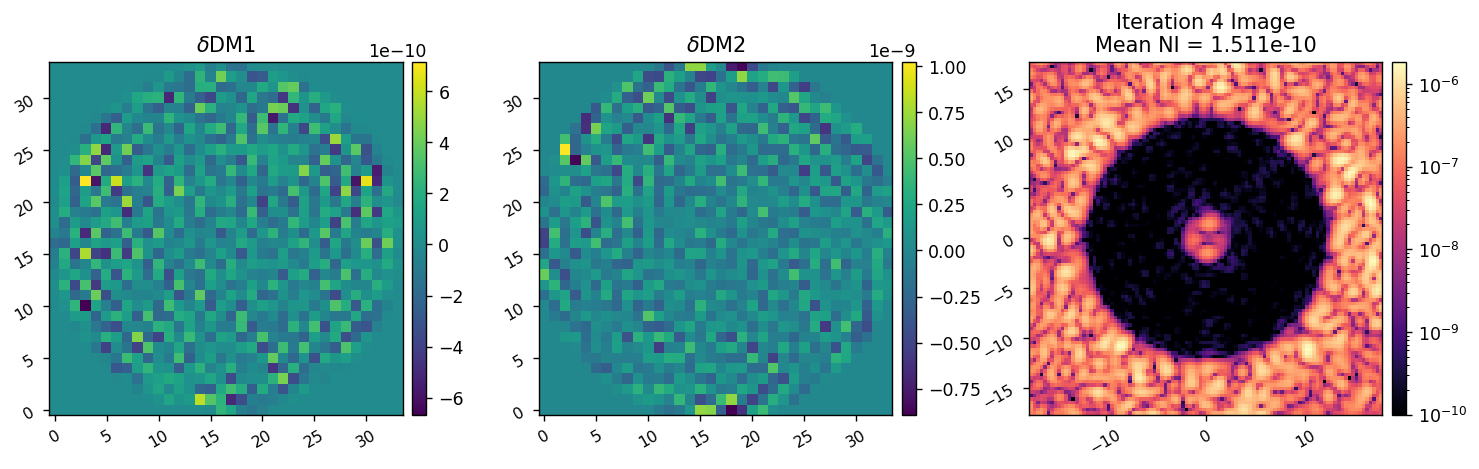

Running estimation algorithm ...
Computing EFC command with L-BFGS
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1904     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  2.30587D+08


 This problem is unconstrained.



At iterate    1    f=  9.21993D-01    |proj g|=  1.68971D+08

At iterate    2    f=  8.86884D-01    |proj g|=  1.22604D+08

At iterate    3    f=  8.42435D-01    |proj g|=  8.60917D+07

At iterate    4    f=  8.22101D-01    |proj g|=  1.29657D+08

At iterate    5    f=  8.02382D-01    |proj g|=  6.10022D+07

At iterate    6    f=  7.86408D-01    |proj g|=  6.85458D+07

At iterate    7    f=  7.75167D-01    |proj g|=  7.73137D+07

At iterate    8    f=  7.63649D-01    |proj g|=  7.91445D+07

At iterate    9    f=  7.55034D-01    |proj g|=  5.31188D+07

At iterate   10    f=  7.47396D-01    |proj g|=  5.11950D+07

At iterate   11    f=  7.37686D-01    |proj g|=  6.84240D+07

At iterate   12    f=  7.28171D-01    |proj g|=  1.12941D+08

At iterate   13    f=  7.16762D-01    |proj g|=  4.88928D+07

At iterate   14    f=  7.09540D-01    |proj g|=  4.32157D+07

At iterate   15    f=  7.02520D-01    |proj g|=  4.67063D+07

At iterate   16    f=  6.98033D-01    |proj g|=  1.62037D+08

At iter

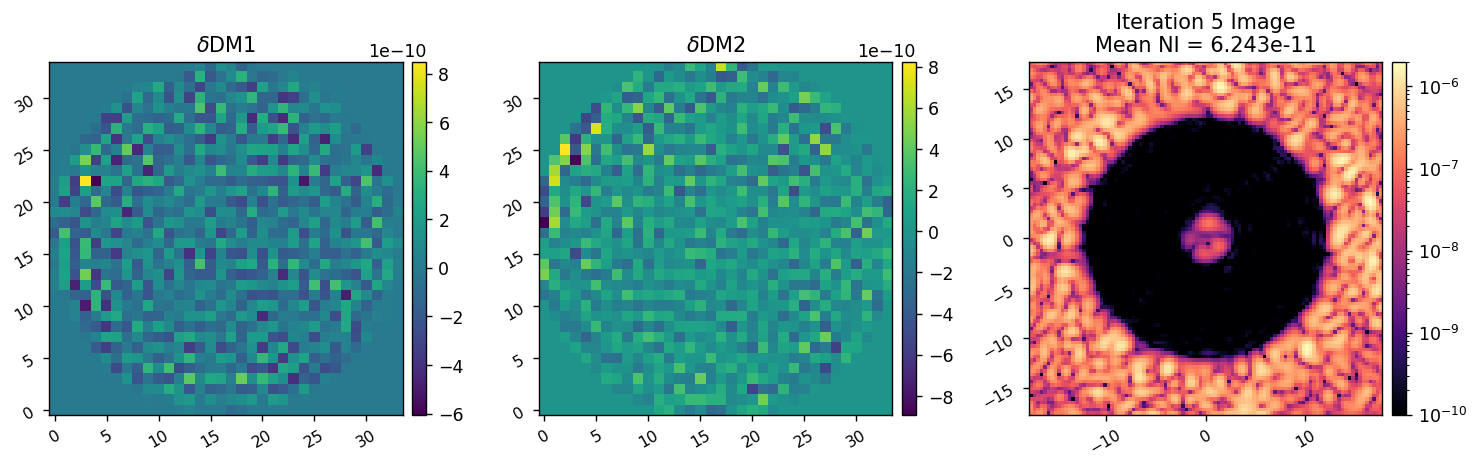

Running estimation algorithm ...
Computing EFC command with L-BFGS
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1904     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  7.23267D+08


 This problem is unconstrained.



At iterate    1    f=  8.71598D-01    |proj g|=  3.01655D+08

At iterate    2    f=  8.19743D-01    |proj g|=  2.11550D+08

At iterate    3    f=  7.72639D-01    |proj g|=  1.52173D+08

At iterate    4    f=  7.45296D-01    |proj g|=  2.96779D+08

At iterate    5    f=  7.22341D-01    |proj g|=  1.24437D+08

At iterate    6    f=  7.11191D-01    |proj g|=  7.56830D+07

At iterate    7    f=  7.01590D-01    |proj g|=  1.05313D+08

At iterate    8    f=  6.97088D-01    |proj g|=  2.26811D+08

At iterate    9    f=  6.90442D-01    |proj g|=  7.12779D+07

At iterate   10    f=  6.87122D-01    |proj g|=  5.58621D+07

At iterate   11    f=  6.82915D-01    |proj g|=  7.86366D+07

At iterate   12    f=  6.76269D-01    |proj g|=  8.89502D+07

At iterate   13    f=  6.72354D-01    |proj g|=  9.84984D+07

At iterate   14    f=  6.68052D-01    |proj g|=  3.51045D+07

At iterate   15    f=  6.64958D-01    |proj g|=  4.76718D+07

At iterate   16    f=  6.61947D-01    |proj g|=  8.15122D+07

At iter

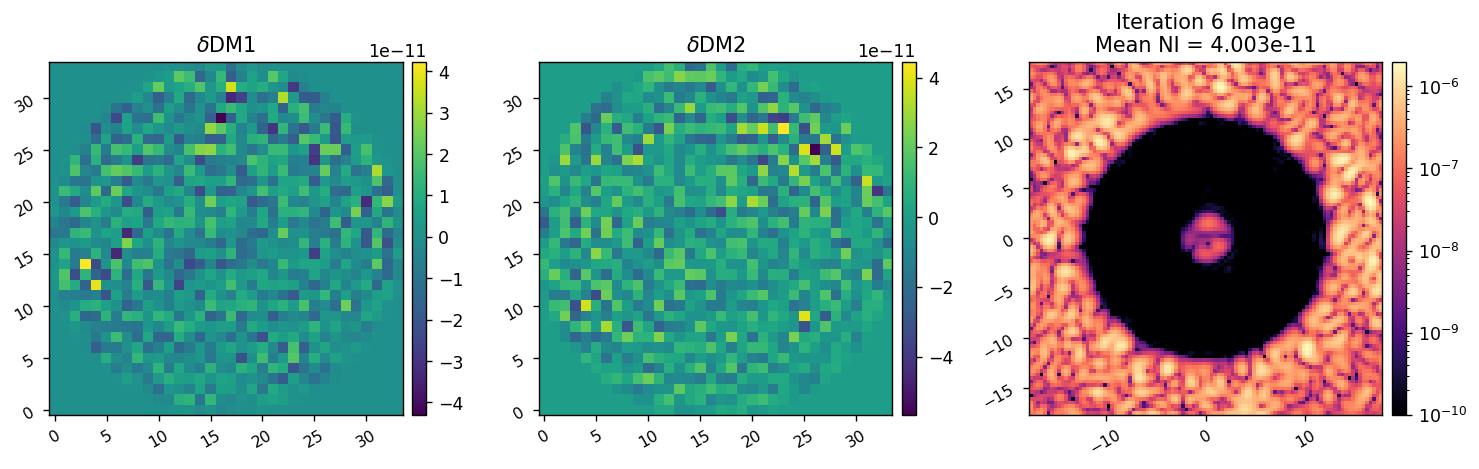

In [23]:
reload(fraunhofer)
reload(adefc)

r_cond = 1e-2
# r_cond = 1e-3
# r_cond = 1e-4
r_cond = 1e-5
# r_cond = 1e-6

bfgs_tol = 1e-2
bfgs_tol = 1e-3
# bfgs_tol = 1e-4
# bfgs_tol = 1e-5

bfgs_opts = {
    'disp':True,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

data = adefc.run(
    I, 
    M, 
    fraunhofer.val_and_grad, 
    control_mask, 
    data,
    Nitr=3, 
    reg_cond=r_cond,
    bfgs_tol=bfgs_tol,
    bfgs_opts=bfgs_opts,
    gain=1,
)

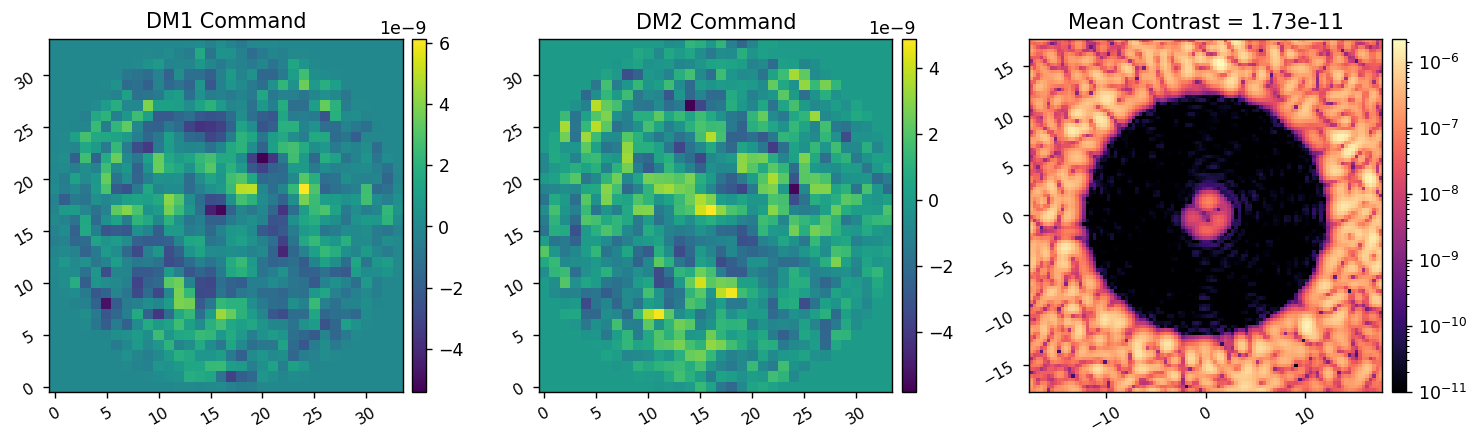

In [44]:
i = 10
mean_ni = xp.mean(data['images'][i][control_mask])
imshow3(data['dm1_commands'][i], data['dm2_commands'][i], data['images'][i], 'DM1 Command', 'DM2 Command', f'Mean Contrast = {mean_ni:.2e}', 
    lognorm3=True, vmin3=1e-11, pxscl3=I.psf_pixelscale_lamDc,
    cmap1='viridis', cmap2='viridis')

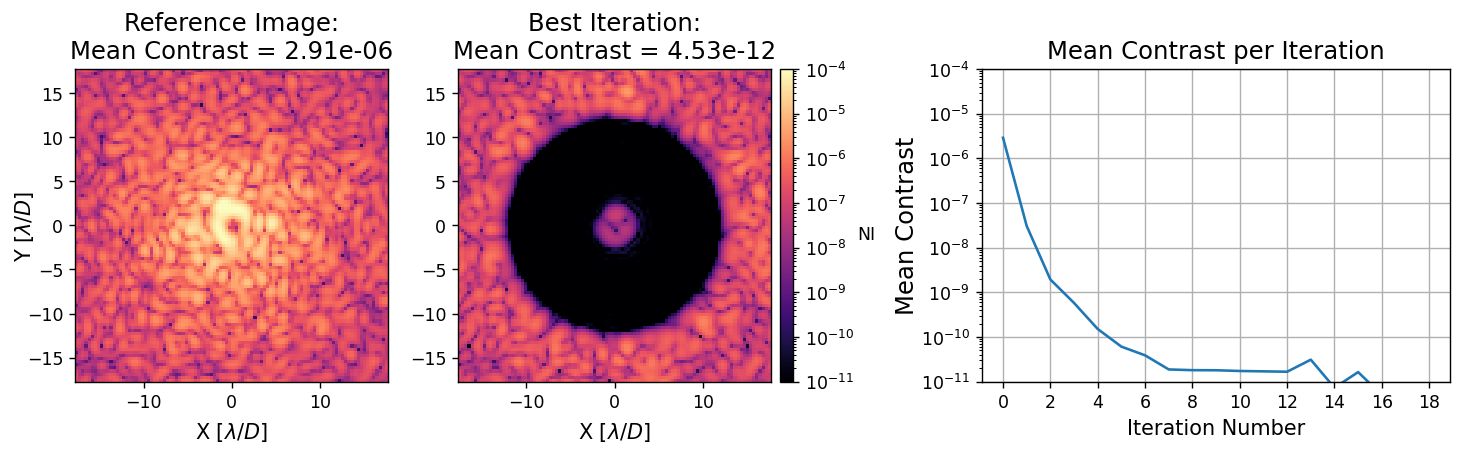

In [37]:
reload(adefc)
adefc.plot_data(data, vmin=1e-11)

In [56]:
Nwaves = 9
wavelength_c = 650e-9
bw = 0.1
waves = np.linspace(wavelength_c * (1-bw/2), wavelength_c * (1+bw/2), Nwaves )
bandpasses = waves.reshape(3,3)
print(bandpasses)

[[6.17500e-07 6.25625e-07 6.33750e-07]
 [6.41875e-07 6.50000e-07 6.58125e-07]
 [6.66250e-07 6.74375e-07 6.82500e-07]]


/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models
1.2490517900632186e-09


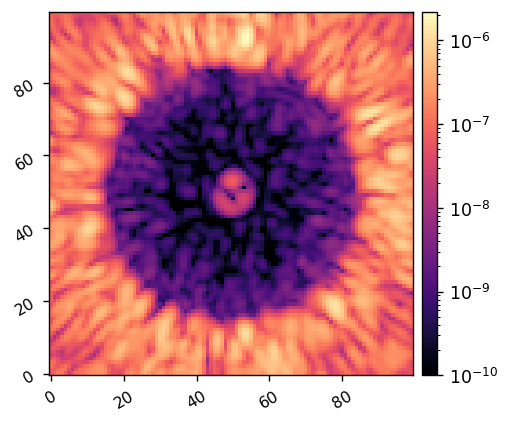

In [57]:
reload(fresnel)
I = fresnel.CORO()
I.use_opds = True
I.bandpasses = bandpasses

I.zero_dms()
I.use_vortex = False
ref_psf = I.snap()
I.Imax_ref = xp.max(ref_psf)

I.set_dm1(data['dm1_commands'][-1])
I.set_dm2(data['dm2_commands'][-1])
I.use_vortex = True
bbim = I.snap()
print(xp.mean(bbim[control_mask]))
imshow1(bbim, lognorm=True, vmin=1e-10)